In [156]:
import requests
import pandas as pd
import numpy as np
import datetime 

In [157]:
import matplotlib.pyplot as plt # pyplot
import matplotlib as mpl # matplotlib
%matplotlib inline

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns # seaborn
import scipy.stats as stats

In [158]:
api_key = 'test_b375f597f54e36891fce7c2f065cd1a95d7a667894ff675e8c0e80d6ff0d63e6efe8d04e6d233bd35cf2fabdeb93fb0d'
headers = {'x-nxopen-api-key': api_key}

In [168]:
match_response = requests.get('https://open.api.nexon.com/static/fconline/meta/matchtype.json', 
                         headers = headers)

print(f"Status Code for division: {match_response.status_code}") 


match_json = match_response.json()
match_df = pd.DataFrame(match_json)
match_df = match_df.rename(columns={'matchtype' : 'matchType'}) 

divison_response = requests.get('https://open.api.nexon.com/static/fconline/meta/division.json', 
                         headers = headers)

print(f"Status Code for division: {divison_response.status_code}") 

division_json = divison_response.json()
division_df = pd.DataFrame(division_json)
division_df = division_df.rename(columns={'divisionId' : 'division'}) 

match_dict = match_df.set_index('matchType')['desc'].to_dict()
division_dict = division_df.set_index('division')['divisionName'].to_dict()

Status Code for division: 200
Status Code for division: 200


In [169]:
match_key = next(k for k, v in match_dict.items() if v == '공식경기')
match_offset = 0
match_limit = 80

attack_position = [i for i in range(9, 20)]
middle_position = [i for i in range(20, 28)]
defense_position = [i for i in range(1, 9)]
goalkeeper_position = [0]

In [167]:
match_params = {'matchtype' : match_key, 
                'offset' : match_offset, 
                'limit' : match_limit}

response_match = requests.get('https://open.api.nexon.com/fconline/v1/match?',  
                    params = match_params, headers = headers)

print(f"Status Code for match: {response_match.status_code}") 

match_id_json = response_match.json()

Status Code for match: 200


NameError: name 'match_id' is not defined

In [170]:
match_user_data = []

new_user_dict = {}

for match_ouid in match_id_json : 
    
    match_detail_params = {'matchid' : match_ouid}

    response_match_detail = requests.get('https://open.api.nexon.com/fconline/v1/match-detail?',  
                        params = match_detail_params, headers = headers)

    if response_match_detail.status_code != 200:
        print(f"Failed to fetch match detail for match_id {match_ouid}")
        continue

    match_detail = response_match_detail.json()
    match_date = match_detail['matchDate']
    
    for match_user in match_detail['matchInfo'] : 
        if match_user['ouid'] not in new_user_dict :
            new_user_dict[match_user['ouid']] = match_user['nickname']
            
        attack_rating = []
        middle_rating = []
        defense_rating = []
        goalkeeper_rating = []
        
        for player in match_user['player'] : 
            if player['spPosition'] == 28 :                             # 후보선수 제외
                continue

            elif player['spPosition'] in attack_position :              # 공격 평점
                attack_rating.append(player['status']['spRating'])

            elif player['spPosition'] in middle_position :              # 미들 평점
                middle_rating.append(player['status']['spRating'])

            elif player['spPosition'] in defense_position :             # 수비 평점
                defense_rating.append(player['status']['spRating'])

            else :                                                      # 골키퍼 평점 
                goalkeeper_rating.append(player['status']['spRating'])
        
        match_user_data.append({
                'match_id': match_ouid,
                'match_date': match_date,
                'user_ouid': match_user['ouid'],
                'user_nickname': match_user['nickname'],
                'match_result':  match_user['matchDetail']['matchResult'] ,
                'match_possession': match_user['matchDetail']['possession'],
                'match_avg_rating': match_user['matchDetail']['averageRating'],
                'match_total_dribble': match_user['matchDetail']['dribble'],
                'match_total_pass_try': match_user['pass']['passTry'],
                'match_total_pass_suc': match_user['pass']['passSuccess'],
                'match_total_shoot': match_user['shoot']['shootTotal'],
                'match_total_shoot_eff': match_user['shoot']['effectiveShootTotal'],
                'match_total_goal': match_user['shoot']['goalTotal'], 
                'attack_position_ratings': round(np.mean(attack_rating), 2),
                'middle_position_ratings': round(np.mean(middle_rating), 2),
                'defense_position_ratings': round(np.mean(defense_rating), 2),
                'goalkeeper_position_ratings': round(np.mean(goalkeeper_rating), 2),

                'match_total_pass_short_try': match_user['pass']['shortPassTry'],
                'match_total_pass_short_suc': match_user['pass']['shortPassSuccess'], 
                'match_total_pass_long_try': match_user['pass']['longPassTry'],
                'match_total_pass_long_suc': match_user['pass']['longPassSuccess'],
                'match_total_pass_through_try': match_user['pass']['throughPassTry'],
                'match_total_pass_through_suc': match_user['pass']['throughPassSuccess'],
                'match_total_shoot_outpenalty_try': match_user['shoot']['shootOutPenalty'],
                'match_total_shoot_outpenalty_suc': match_user['shoot']['goalOutPenalty'],
                'match_total_shoot_inpenalty_try': match_user['shoot']['shootInPenalty'],
                'match_total_shoot_inpenalty_suc': match_user['shoot']['goalInPenalty']
                })

C:\Users\dohyu\miniconda3\envs\project2\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\dohyu\miniconda3\envs\project2\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [171]:
match_user_df = pd.DataFrame(match_user_data)

In [172]:
match_user_df

,match_id,match_date,user_ouid,user_nickname,match_result,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,...,match_total_pass_short_try,match_total_pass_short_suc,match_total_pass_long_try,match_total_pass_long_suc,match_total_pass_through_try,match_total_pass_through_suc,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
0,67582d15540d03ce1eda4a83,2024-12-10T11:59:20,bd00397c7e953271e326709a34a8543b,송도동송민규,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67582cf0ff1a3766b490b9ec,2024-12-10T11:59:41,dc367f34d04e2aca4f575230140e0a3c,20220304,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67582cddef8a59b9c0e3b65d,2024-12-10T11:58:33,a786b5c792951533a4d76f82bd3dc94c,왕즈지훈입니다,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67582cd00e6c9cc5bbb99b63,2024-12-10T11:59:00,8b996e667dd1975706a1372c48350440,애릭다먹어,패,100.0,3.88333,1.0,3.0,2.0,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,67582cd00e6c9cc5bbb99b63,2024-12-10T11:59:00,2f4314a58161813b6095f4baffd0dc33,Mint07,승,0.0,3.66667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,67582bde7016c840e0856d5c,2024-12-10T11:59:02,849d6498708a1851d941e4b9ae29ed07,롯데리아매이트,패,41.0,3.09444,26.0,43.0,36.0,...,32.0,29.0,0.0,0.0,10.0,7.0,0.0,0.0,0.0,0.0
117,67582bde4886501ff13026c5,2024-12-10T11:57:26,676ebcf5ef687741a3a0ef1e830b0d42,류느님,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,67582bddc1b29065846cb9e7,2024-12-10T11:59:15,b429f74da2baa1957d46bf9f9c28bfbf,도토루맛있쩡,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,67582bdd9f3f4b1f81882a9c,2024-12-10T11:57:47,6b855246104a7172c707ad3f02b36f70,판타스틱준,패,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
match_user_df.isna().sum()

match_id                             0
match_date                           0
user_ouid                            0
user_nickname                        0
match_result                         0
match_possession                    45
match_avg_rating                    45
match_total_dribble                 45
match_total_pass_try                45
match_total_pass_suc                45
match_total_shoot                   45
match_total_shoot_eff               45
match_total_goal                    45
attack_position_ratings             45
middle_position_ratings             45
defense_position_ratings            45
goalkeeper_position_ratings         45
match_total_pass_short_try          45
match_total_pass_short_suc          45
match_total_pass_long_try           45
match_total_pass_long_suc           45
match_total_pass_through_try        45
match_total_pass_through_suc        45
match_total_shoot_outpenalty_try    45
match_total_shoot_outpenalty_suc    45
match_total_shoot_inpenal

In [174]:
filtered_match_user_df = match_user_df.dropna()
filtered_match_user_df[50:]

,match_id,match_date,user_ouid,user_nickname,match_result,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,...,match_total_pass_short_try,match_total_pass_short_suc,match_total_pass_long_try,match_total_pass_long_suc,match_total_pass_through_try,match_total_pass_through_suc,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
86,67582c05af4d3b38aa033c48,2024-12-10T11:59:46,9cc5e6828a9ffc1cdebc61cd166d0ecd,메시함,패,53.0,3.20000,31.0,54.0,44.0,...,39.0,37.0,3.0,0.0,11.0,7.0,0.0,0.0,1.0,0.0
88,67582c006d6436bfa316d4be,2024-12-10T11:56:05,82089fe064c8093673f9864552bc6f24,뻑뻑살,승,70.0,3.66111,8.0,9.0,9.0,...,8.0,8.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
89,67582c006d6436bfa316d4be,2024-12-10T11:56:05,1cb77382a8d5e4bdef062b3485c862ce,abckjeifdk,패,30.0,3.80556,2.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,67582c000efe4921350dbe4b,2024-12-10T11:57:03,47ffd65b7df2f4cedb7cd469b1153c11,KODEX곱버스,패,30.0,3.28889,6.0,11.0,9.0,...,4.0,4.0,0.0,0.0,6.0,5.0,0.0,0.0,0.0,0.0
91,67582c000efe4921350dbe4b,2024-12-10T11:57:03,1190dcbedbe09184ce92d3ab554169aa,jsk0609,승,70.0,4.08889,22.0,26.0,24.0,...,19.0,18.0,1.0,1.0,4.0,4.0,1.0,0.0,2.0,1.0
92,67582bfdd9dd5c38f5ae4eb0,2024-12-10T11:59:34,4bffd46f5803e655d143ce04613b3933,기득춘,승,53.0,4.32778,39.0,55.0,48.0,...,32.0,31.0,2.0,1.0,19.0,16.0,1.0,0.0,3.0,2.0
93,67582bfdd9dd5c38f5ae4eb0,2024-12-10T11:59:34,bec10628c3e73ec255696cdf0ef18258,아니이름할거없다,패,47.0,3.42778,19.0,25.0,21.0,...,18.0,16.0,1.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0
94,67582bf985af8364c6c55f53,2024-12-10T11:59:55,432526d32f96036396a697f93040b719,albireo08,패,48.0,3.51111,30.0,50.0,45.0,...,38.0,35.0,3.0,3.0,9.0,7.0,2.0,0.0,3.0,0.0
95,67582bf945888c9d4f9c1070,2024-12-10T11:56:37,ea348a17f80fc5c1f57b9f8514ebe53c,초록공룡,패,68.0,3.85556,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,67582bf945888c9d4f9c1070,2024-12-10T11:56:37,e37c35710c209bdeb0768e72c5379048,KeEpGoinG0,승,26.0,3.69444,9.0,10.0,10.0,...,6.0,6.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0


In [175]:
new_user_dict

{'bd00397c7e953271e326709a34a8543b': '송도동송민규',
 'dc367f34d04e2aca4f575230140e0a3c': '20220304',
 'a786b5c792951533a4d76f82bd3dc94c': '왕즈지훈입니다',
 '8b996e667dd1975706a1372c48350440': '애릭다먹어',
 '2f4314a58161813b6095f4baffd0dc33': 'Mint07',
 '136b08d6eab53fd3c106a51af8d8c9f4': '레알마드로스',
 '155ebce6866492473d8ef5ce11e45713': '리코타치즈돈가스',
 '45b5ff367dfbe4d2e85811795be67965': '박씨마누라옆자리',
 '44b1a478434bdccdef5969645765fde8': 'Z1ZOU',
 '8641ea998a5ce1ef579ddcf9b66daeb4': '레알Ma드리드',
 '82f06e6dc8dd58a034afef89fd4dfea4': '지네딘찌단',
 'c5a95495546dc83e273b3deb61841324': '쎀갤러',
 '8339960e22a3d8949959846d42bc14f8': '상개동작두',
 'b73c15ab00012b20d48d92ad59b56f47': '핏똥살라',
 '76d47285c1914bb7849566206ec2a988': 'garcello',
 '3d758147074a769544581656c5aa1c04': '대한건아들',
 '9e8b6ac7f52da17cad4543f99cf69943': 'Geobu',
 'c8e1d19b945eda0cefca3f8b4c08349d': '유벤투스우승가자',
 'deace87feb062a7ee457dd0ffa92b11a': '꼼짝옴짝',
 'f6da8541788bc336e9722a8d1e6283a3': '억까하네',
 'd8416023010f5c35f78964f3ec60baac': '바르샤고고고',
 '53f7142059a29e

###################################################################################################################

In [176]:
# mysql> create table test (
#    -> id bigint not null,
#    -> seq bigint not null,
#    -> primary key(id, seq)
#    -> );
# Query OK, 0 rows affected (0.01 sec)

In [177]:
from sqlalchemy import create_engine, text
import pandas as pd

db_conn = {
     "user": "root",
     "password": "Dhyoon96!",
     "host": "127.0.0.1",
     "database": "side_proj_FCO"
 }

db_engine = "mysql+pymysql://%s:%s@%s/%s" % (
    db_conn["user"],
    db_conn["password"],
    db_conn["host"],
    db_conn["database"]
)

engine = create_engine(db_engine, echo=True)

In [178]:
create_match_user_table_query = """
    CREATE TABLE IF NOT EXISTS match_user (
        match_id VARCHAR(40),         
        user_ouid VARCHAR(40),        
        user_nickname VARCHAR(50),      
        match_result VARCHAR(5),                             
        match_possession INT,                               
        match_avg_rating FLOAT,                              
        match_total_dribble INT,                              
        match_total_pass_try INT,                             
        match_total_pass_suc INT,                             
        match_total_shoot INT,                                
        match_total_shoot_eff INT,                            
        match_total_goal INT,         
        attack_position_ratings FLOAT,
        middle_position_ratings FLOAT,
        defense_position_ratings FLOAT,
        goalkeeper_position_ratings FLOAT,                       
        match_total_pass_short_try INT,
        match_total_pass_short_suc INT,
        match_total_pass_long_try INT,
        match_total_pass_long_suc INT,
        match_total_pass_through_try INT,
        match_total_pass_through_suc INT,
        match_total_shoot_outpenalty_try INT,
        match_total_shoot_outpenalty_suc INT,
        match_total_shoot_inpenalty_try INT,
        match_total_shoot_inpenalty_suc INT, 
        
        PRIMARY KEY (match_id, user_ouid)
    );   
    """

insert_match_user_table_query = """
    INSERT IGNORE INTO match_user (match_id, user_ouid, user_nickname, match_result, match_possession, match_avg_rating, 
                                   match_total_dribble, match_total_pass_try, match_total_pass_suc, match_total_shoot, 
                                   match_total_shoot_eff, match_total_goal, 
                                   attack_position_ratings, middle_position_ratings, defense_position_ratings, goalkeeper_position_ratings,
                                   match_total_pass_short_try, match_total_pass_short_suc, 
                                   match_total_pass_long_try, match_total_pass_long_suc, 
                                   match_total_pass_through_try, match_total_pass_through_suc, 
                                   match_total_shoot_outpenalty_try, match_total_shoot_outpenalty_suc, 
                                   match_total_shoot_inpenalty_try, match_total_shoot_inpenalty_suc)
    VALUES (:match_id, :user_ouid, :user_nickname, :match_result, :match_possession, :match_avg_rating, 
            :match_total_dribble, :match_total_pass_try, :match_total_pass_suc, :match_total_shoot, 
            :match_total_shoot_eff, :match_total_goal,
            :attack_position_ratings, :middle_position_ratings, :defense_position_ratings, :goalkeeper_position_ratings,
            :match_total_pass_short_try, :match_total_pass_short_suc, 
            :match_total_pass_long_try, :match_total_pass_long_suc, 
            :match_total_pass_through_try, :match_total_pass_through_suc, 
            :match_total_shoot_outpenalty_try, :match_total_shoot_outpenalty_suc, 
            :match_total_shoot_inpenalty_try, :match_total_shoot_inpenalty_suc);
            """

create_user_metadata_table_query = """
    CREATE TABLE IF NOT EXISTS user_metadata (
        user_ouid VARCHAR(40) PRIMARY KEY,
        user_nickname VARCHAR(50) NOT NULL);
    """

insert_user_metadata_table_query = """
    INSERT IGNORE INTO user_metadata (user_ouid, user_nickname)
    VALUES (:user_ouid, :user_nickname);    
    """

In [179]:
with engine.connect() as connection:
    trans = connection.begin()  # 트랜잭션 시작
    
    try:
        connection.execute(text(create_match_user_table_query))
        connection.execute(text(create_user_metadata_table_query))

        try:
            for new_user_ouid, new_user_nickname in new_user_dict.items() : 
                connection.execute(
                    text(insert_user_metadata_table_query),
                    {'user_ouid': new_user_ouid, 'user_nickname': new_user_nickname}
                )
            for index, row in filtered_match_user_df.iterrows():
                connection.execute(text(insert_match_user_table_query), {
                    'match_id': row['match_id'],
                    'user_ouid': row['user_ouid'],
                    'user_nickname': row['user_nickname'],
                    'match_result': row['match_result'],
                    'match_possession': row['match_possession'],
                    'match_avg_rating': row['match_avg_rating'],
                    'match_total_dribble': row['match_total_dribble'],
                    'match_total_pass_try': row['match_total_pass_try'],
                    'match_total_pass_suc': row['match_total_pass_suc'],
                    'match_total_shoot': row['match_total_shoot'],
                    'match_total_shoot_eff': row['match_total_shoot_eff'],
                    'match_total_goal': row['match_total_goal'], 
                    'attack_position_ratings': row['attack_position_ratings'],
                    'middle_position_ratings': row['middle_position_ratings'],
                    'defense_position_ratings': row['defense_position_ratings'],
                    'goalkeeper_position_ratings': row['goalkeeper_position_ratings'],
                    'match_total_pass_short_try': row['match_total_pass_short_try'],
                    'match_total_pass_short_suc': row['match_total_pass_short_suc'],
                    'match_total_pass_long_try': row['match_total_pass_long_try'],
                    'match_total_pass_long_suc': row['match_total_pass_long_suc'],
                    'match_total_pass_through_try': row['match_total_pass_through_try'],
                    'match_total_pass_through_suc': row['match_total_pass_through_suc'],
                    'match_total_shoot_outpenalty_try': row['match_total_shoot_outpenalty_try'],
                    'match_total_shoot_outpenalty_suc': row['match_total_shoot_outpenalty_suc'],
                    'match_total_shoot_inpenalty_try': row['match_total_shoot_inpenalty_try'],
                    'match_total_shoot_inpenalty_suc': row['match_total_shoot_inpenalty_suc']
                    })

        except Exception as insert_e:
            print(f"데이터 추가 중 오류가 발생했습니다: {insert_e}")
            trans.rollback()  
            raise  # 오류를 다시 발생시켜 외부 `except`에서 처리 가능하게 함
        
        trans.commit() 
        
    except Exception as create_e:
        print(f"테이블 생성 중 오류가 발생했습니다: {create_e}")
        trans.rollback()

2024-12-10 22:55:18,327 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-12-10 22:55:18,329 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-10 22:55:18,331 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-12-10 22:55:18,332 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-10 22:55:18,333 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-12-10 22:55:18,335 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-10 22:55:18,337 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-12-10 22:55:18,338 INFO sqlalchemy.engine.Engine 
    CREATE TABLE IF NOT EXISTS match_user (
        match_id VARCHAR(40),         
        user_ouid VARCHAR(40),        
        user_nickname VARCHAR(50),      
        match_result VARCHAR(5),                             
        match_possession INT,                               
        match_avg_rating FLOAT,                              
        match_total_dribble INT,                              
        match_total_pass_try INT

2024-12-10 22:55:18,346 INFO sqlalchemy.engine.Engine 
    CREATE TABLE IF NOT EXISTS user_metadata (
        user_ouid VARCHAR(40) PRIMARY KEY,
        user_nickname VARCHAR(50) NOT NULL);
    
2024-12-10 22:55:18,346 INFO sqlalchemy.engine.Engine [generated in 0.00087s] {}
2024-12-10 22:55:18,352 INFO sqlalchemy.engine.Engine 
    INSERT IGNORE INTO user_metadata (user_ouid, user_nickname)
    VALUES (%(user_ouid)s, %(user_nickname)s);    
    
2024-12-10 22:55:18,353 INFO sqlalchemy.engine.Engine [generated in 0.00141s] {'user_ouid': 'bd00397c7e953271e326709a34a8543b', 'user_nickname': '송도동송민규'}
2024-12-10 22:55:18,356 INFO sqlalchemy.engine.Engine 
    INSERT IGNORE INTO user_metadata (user_ouid, user_nickname)
    VALUES (%(user_ouid)s, %(user_nickname)s);    
    
2024-12-10 22:55:18,358 INFO sqlalchemy.engine.Engine [cached since 0.006749s ago] {'user_ouid': 'dc367f34d04e2aca4f575230140e0a3c', 'user_nickname': '20220304'}
2024-12-10 22:55:18,360 INFO sqlalchemy.engine.Engine 
  

In [180]:
engine.dispose()

---

---

# Vanila Model (RandomForestClassifier)

In [181]:
from sqlalchemy import create_engine, text
import pandas as pd

db_conn = {
     "user": "root",
     "password": "Dhyoon96!",
     "host": "127.0.0.1",
     "database": "side_proj_FCO"
 }

db_engine = "mysql+pymysql://%s:%s@%s/%s" % (
    db_conn["user"],
    db_conn["password"],
    db_conn["host"],
    db_conn["database"]
)

engine = create_engine(db_engine, echo=True)

In [182]:
df_query = 'SELECT * FROM match_user'
df1 = pd.read_sql(df_query, con = engine)

2024-12-10 22:55:24,001 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-12-10 22:55:24,002 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-10 22:55:24,004 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-12-10 22:55:24,006 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-10 22:55:24,007 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-12-10 22:55:24,008 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-10 22:55:24,011 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2024-12-10 22:55:24,012 INFO sqlalchemy.engine.Engine [generated in 0.00135s] {'table_schema': 'side_proj_fco', 'table_name': 'SELECT * FROM match_user'}


2024-12-10 22:55:24,020 INFO sqlalchemy.engine.Engine SELECT * FROM match_user
2024-12-10 22:55:24,022 INFO sqlalchemy.engine.Engine [raw sql] {}


In [183]:
df1

,match_id,user_ouid,user_nickname,match_result,match_possession,match_avg_rating,match_total_dribble,match_total_pass_try,match_total_pass_suc,match_total_shoot,...,match_total_pass_short_try,match_total_pass_short_suc,match_total_pass_long_try,match_total_pass_long_suc,match_total_pass_through_try,match_total_pass_through_suc,match_total_shoot_outpenalty_try,match_total_shoot_outpenalty_suc,match_total_shoot_inpenalty_try,match_total_shoot_inpenalty_suc
0,67418a50fcfb86525b068dc9,c5bd2d238afff4775b5e6bc5c928e31c,SaddIerS3,승,70,4.08333,19,19,17,4,...,12,12,1,0,6,5,2,1,2,0
1,67418a525b7f6b04d21d13d4,a49aaacc626c90bca37e175eb31ec288,A헤가오,승,59,4.17222,17,32,28,4,...,26,23,0,0,6,5,2,1,1,1
2,67418a563909e504f56f8222,623d56892e95056759904c52507a366a,대북중1짱,패,47,3.76111,21,25,23,0,...,12,12,0,0,13,11,0,0,0,0
3,67418a58060e19029147892c,0db87e3296072311b38a1c19fc243939,LanderSSG,승,53,4.14444,23,32,29,1,...,24,23,2,0,6,6,0,0,1,1
4,67418a5b49725df11f881dad,48d376ea55efee991a7155369a1fa951,호날두lol,승,48,4.45556,32,44,44,7,...,40,40,1,1,2,2,3,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,67582ca9d47b285fa80587f4,c5a95495546dc83e273b3deb61841324,쎀갤러,패,36,3.67222,3,4,4,1,...,3,3,0,0,0,0,0,0,1,0
2204,67582caca64851f7cb76ffde,82f06e6dc8dd58a034afef89fd4dfea4,지네딘찌단,승,87,4.41667,7,12,11,3,...,11,11,1,0,0,0,1,0,2,1
2205,67582cc2f42c3849909378ec,155ebce6866492473d8ef5ce11e45713,리코타치즈돈가스,승,57,3.81111,3,5,5,1,...,4,4,0,0,1,1,1,0,0,0
2206,67582cd00e6c9cc5bbb99b63,2f4314a58161813b6095f4baffd0dc33,Mint07,승,0,3.66667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
position_ratings_col = ['attack_position_ratings', 
                        'middle_position_ratings', 
                        'defense_position_ratings', 
                        'goalkeeper_position_ratings']

In [185]:
df2 = df1.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 
                          'match_avg_rating', 'match_total_goal',
                          'match_total_dribble', 'match_total_pass_try', 'match_total_pass_suc',
                          'match_total_shoot', 'match_total_shoot_eff', 
                          'match_total_pass_short_suc', 
                          'match_total_pass_through_suc', 
                          'match_total_pass_long_suc', 
                          'match_total_shoot_outpenalty_suc', 
                          'match_total_shoot_inpenalty_suc']
                          + position_ratings_col)

In [186]:
df2

,match_result,match_possession,match_total_pass_short_try,match_total_pass_long_try,match_total_pass_through_try,match_total_shoot_outpenalty_try,match_total_shoot_inpenalty_try
0,승,70,12,1,6,2,2
1,승,59,26,0,6,2,1
2,패,47,12,0,13,0,0
3,승,53,24,2,6,0,1
4,승,48,40,1,2,3,4
...,...,...,...,...,...,...,...
2203,패,36,3,0,0,0,1
2204,승,87,11,1,0,1,2
2205,승,57,4,0,1,1,0
2206,승,0,0,0,0,0,0


In [187]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 특성과 타겟 분리
X_1 = df2.drop('match_result', axis = 1)
y_1 = df2['match_result']

# 학습/테스트 데이터 분할
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.2, random_state = 42, stratify = y_1)

scaler = MinMaxScaler()
X_1_train_scaled = scaler.fit_transform(X_1_train)
X_1_test_scaled = scaler.transform(X_1_test)

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

# 모델 초기화 및 학습
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_1_train_scaled, y_1_train)

# 예측
y_1_pred = model_1.predict(X_1_test_scaled)

# 평가
print("Accuracy:", accuracy_score(y_1_test, y_1_pred))
print("\nClassification Report:\n", classification_report(y_1_test, y_1_pred))

Accuracy: 0.8484162895927602

Classification Report:
               precision    recall  f1-score   support

           승       0.86      0.85      0.86       236
           패       0.83      0.84      0.84       206

    accuracy                           0.85       442
   macro avg       0.85      0.85      0.85       442
weighted avg       0.85      0.85      0.85       442



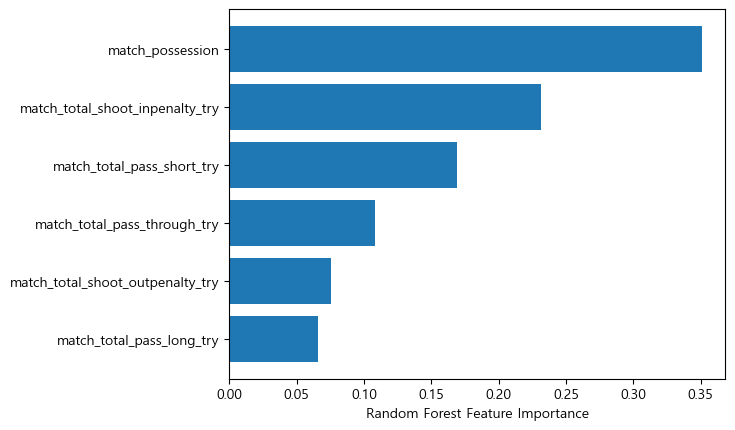

In [189]:
feature_importance = model_1.feature_importances_
sorted_idx = feature_importance.argsort()

plt.barh(X_1.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

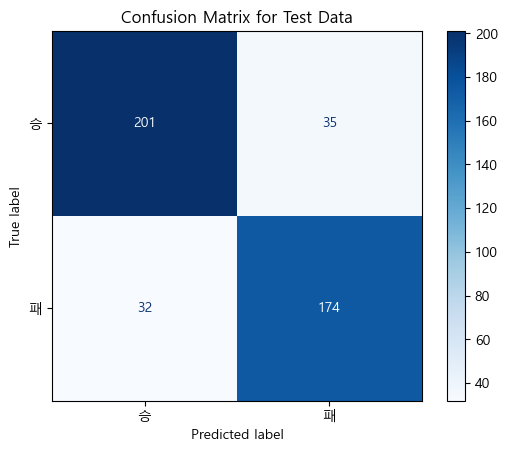

In [190]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_1_test, y_1_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Test Data")
plt.show()

---

---

Fold 1 Validation Accuracy: 0.8475
Fold 2 Validation Accuracy: 0.8187
Fold 3 Validation Accuracy: 0.8272
Fold 4 Validation Accuracy: 0.7960
Fold 5 Validation Accuracy: 0.8385

Mean Validation Accuracy across folds: 0.8256

Test Accuracy: 0.8371040723981901

Classification Report on Test Set:
               precision    recall  f1-score   support

           승       0.85      0.84      0.85       236
           패       0.82      0.83      0.83       206

    accuracy                           0.84       442
   macro avg       0.84      0.84      0.84       442
weighted avg       0.84      0.84      0.84       442



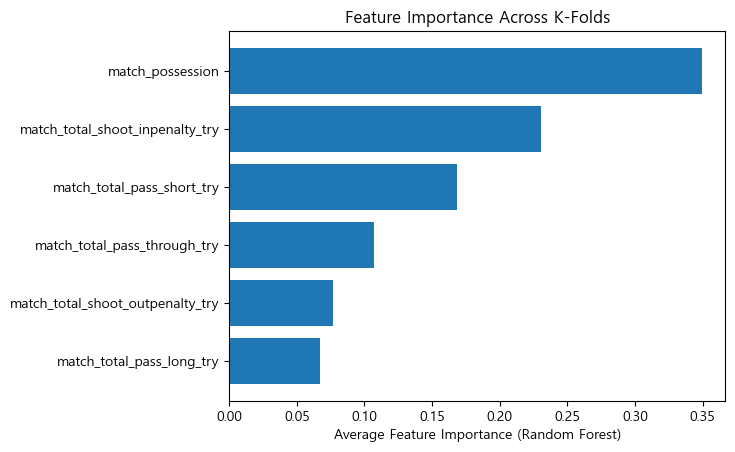

In [191]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 특성과 타겟 분리
X_2 = df2.drop('match_result', axis=1)
y_2 = df2['match_result']

# 테스트 데이터 분리 (최종 평가용)
X_2_temp, X_2_test, y_2_temp, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=y_1)

# K-Fold 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
feature_importance_accumulated = np.zeros(X_2.shape[1])

# 모델 초기화
model_2 = RandomForestClassifier(random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_2_temp, y_2_temp), 1):
    # Train / Validation Split
    X_2_train, X_2_val = X_2_temp.iloc[train_idx], X_2_temp.iloc[val_idx]
    y_2_train, y_2_val = y_2_temp.iloc[train_idx], y_2_temp.iloc[val_idx]
    
    # 데이터 스케일링
    scaler = MinMaxScaler()
    X_2_train_scaled = scaler.fit_transform(X_2_train)
    X_2_val_scaled = scaler.transform(X_2_val)
    
    # 모델 학습
    model_2.fit(X_2_train_scaled, y_2_train)
    
    # 검증 데이터 평가
    y_2_val_pred = model_2.predict(X_2_val_scaled)
    val_accuracy = accuracy_score(y_2_val, y_2_val_pred)
    fold_accuracies.append(val_accuracy)
    
    print(f"Fold {fold} Validation Accuracy: {val_accuracy:.4f}")
    
    # 피처 중요도 누적
    feature_importance_accumulated += model_2.feature_importances_

# 평균 검증 정확도
print(f"\nMean Validation Accuracy across folds: {np.mean(fold_accuracies):.4f}")

# 최종 테스트 데이터 평가
X_2_test_scaled = scaler.transform(X_2_test)
y_2_test_pred = model_2.predict(X_2_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_2_test, y_2_test_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_2_test, y_2_test_pred))

# 피처 중요도 시각화
feature_importance_avg = feature_importance_accumulated / kf.get_n_splits()
sorted_idx = feature_importance_avg.argsort()

plt.barh(X_2.columns[sorted_idx], feature_importance_avg[sorted_idx])
plt.xlabel("Average Feature Importance (Random Forest)")
plt.title("Feature Importance Across K-Folds")
plt.show()

In [195]:
# 실제 값과 예측 값을 데이터프레임으로 저장
test_results = pd.DataFrame({
    'Actual': y_2_test.values,
    'Predicted': y_2_test_pred
})

# 결과 확인
print(test_results)  # 상위 10개 데이터 출력

    Actual Predicted
0        승         승
1        승         승
2        승         승
3        승         승
4        승         승
..     ...       ...
437      승         승
438      승         승
439      패         패
440      패         패
441      승         패

[442 rows x 2 columns]


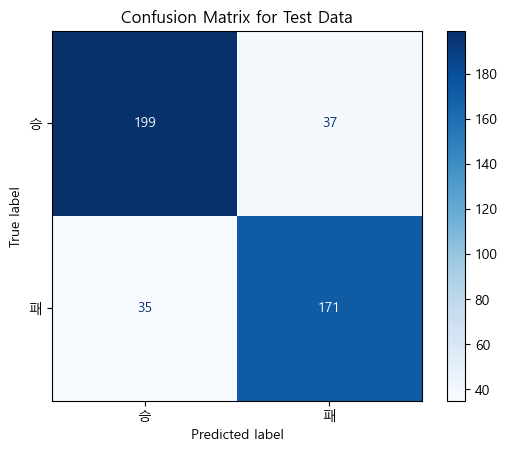

In [193]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_2_test, y_2_test_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Test Data")
plt.show()

In [194]:
# 클래스 분포 확인
print("Training Data Distribution:")
print(y_2_train.value_counts(normalize=True))

print("\nTest Data Distribution:")
print(y_2_test.value_counts(normalize=True))

Training Data Distribution:
match_result
승    0.532909
패    0.467091
Name: proportion, dtype: float64

Test Data Distribution:
match_result
승    0.533937
패    0.466063
Name: proportion, dtype: float64
